In [1]:
%matplotlib inline

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import imageio
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants
INPUT_FOLDER = '/home/gaetano/Desktop/DATA/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

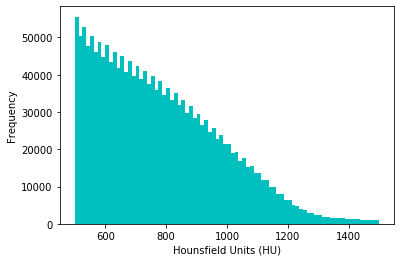

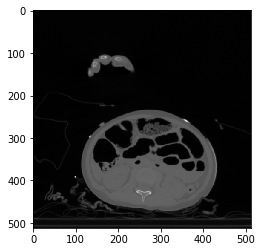

In [4]:

first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)

# Show histogram of Hounsfield density bins
plt.hist(first_patient_pixels.flatten(), bins=80, range=(500, 1500) ,color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [5]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    spacing = np.array([float(scan[0].SliceThickness)] + [float(x) for x in scan[0].PixelSpacing], dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

In [6]:
# Resample volumn

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1, 1, 1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (943, 512, 512)
Shape after resampling	 (472, 335, 335)


In [7]:
def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)

    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

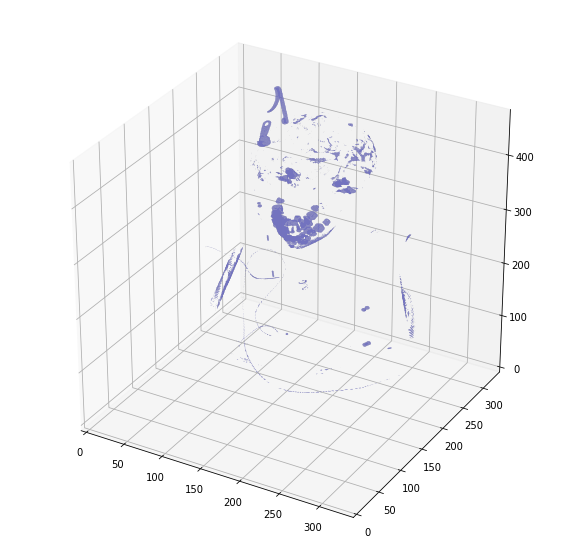

In [8]:
plot_3d(pix_resampled, 1200)

In [9]:
def make_gifs(ctvol, outprefix, chosen_views):
    """Save GIFs of the <ctvol> in the axial, sagittal, and coronal planes.
    This assumes the final orientation produced by the preprocess_volumes.py
    script: [slices, square, square].

    <chosen_views> is a list of strings that can contain any or all of
        ['axial','coronal','sagittal']. It specifies which view(s) will be
        made into gifs."""
    #https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

    #First fix the grayscale colors.
    #imageio assumes only 256 colors (uint8): https://stackoverflow.com/questions/41084883/imageio-how-to-increase-quality-of-output-gifs
    #If you do not truncate to a 256 range, imageio will do so on a per-slice
    #basis, which creates weird brightening and darkening artefacts in the gif.
    #Thus, before making the gif, you should truncate to the 0-256 range
    #and cast to a uint8 (the dtype imageio requires):
    #how to truncate to 0-256 range: https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range
    ctvol = np.clip(ctvol, a_min=-800, a_max=400)
    ctvol = (  ((ctvol+800)*(255))/(400+800)  ).astype('uint8')

    #Now create the gifs in each plane
    if 'axial' in chosen_views:
        images = []
        for slicenum in range(ctvol.shape[0]):
            images.append(ctvol[slicenum,:,:])
        images.reverse()
        imageio.mimsave(outprefix+'_axial.gif',images)
        print('\t\tdone with axial gif')

    if 'coronal' in chosen_views:
        images = []
        for slicenum in range(ctvol.shape[1]):
            images.append(ctvol[:,slicenum,:])
        imageio.mimsave(outprefix+'_coronal.gif',images)
        print('\t\tdone with coronal gif')

    if 'sagittal' in chosen_views:
        images = []
        for slicenum in range(ctvol.shape[2]):
            images.append(ctvol[:,:,slicenum])
        imageio.mimsave(outprefix+'_sagittal.gif',images)
        print('\t\tdone with sagittal gif')

In [10]:
# vv = visualize_volumes.ImageSliceViewer3D(pix_resampled)
make_gifs(pix_resampled, "test_gif", "axial")

		done with axial gif


![SegmentLocal](test_gif_axial.gif "segment")